# ImageNet Model

In [1]:
import os
import sys
import torch
import numpy as np
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
sys.path.append('../taming-transformers')
sys.path.append('../latent-diffusion')
from ldm.util import instantiate_from_config
from ldm.data.ct_rsna import CTSubset

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
ds = CTSubset('../data/ct-rsna/train/', 'train_set_dropped_nans.csv',size=256, flip_prob=0.5, subset_len=1024)

Data source: train_set_dropped_nans.csv
    Class none: 51.0%
    Class epidural: 10.2%
    Class intraparenchymal: 9.2%
    Class intraventricular: 10.8%
    Class subarachnoid: 9.3%
    Class subdural: 9.6%


In [4]:
def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("../latent-diffusion/configs/latent-diffusion/cin256-v2.yaml")  
    model = load_model_from_config(config, "../latent-diffusion/models/ldm/cin256-v2/model.ckpt")
    return model

In [5]:
# !mkdir -p ../latent-diffusion/models/ldm/cin256-v2
# !wget -O ../latent-diffusion/models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt 

In [6]:
model = get_model().to(device)

Loading model from ../latent-diffusion/models/ldm/cin256-v2/model.ckpt


/opt/conda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [34]:
@torch.no_grad()
def encode_decode(x):
    # HxWxC -> 1xCxHxW
    x = x.permute(2, 0, 1).unsqueeze(0)
    encoder_posterior = model.encode_first_stage(x)
    z = model.get_first_stage_encoding(encoder_posterior)
    xout = model.decode_first_stage(z).squeeze().permute(1, 2, 0)
    return (xout + 1) / 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


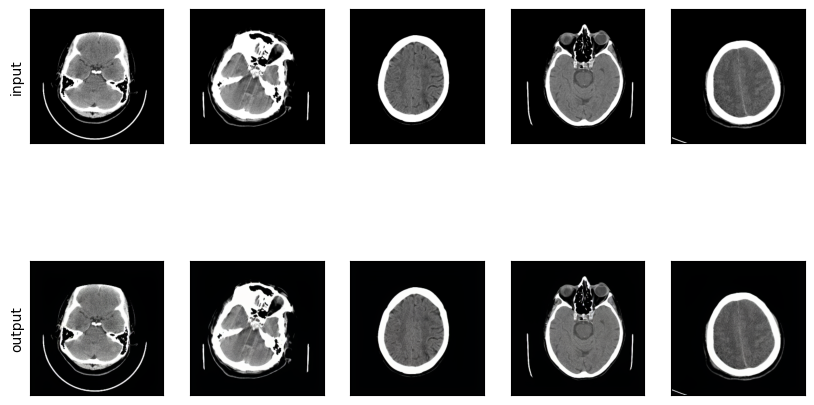

In [36]:
np.random.seed(7)
K = 5
k_samples = np.random.choice(len(ds), K)

fig, ax = plt.subplots(2, K, figsize=(10, 6), sharex=True, sharey=True)
for i in range(K):
    x = ds[k_samples[i]]['image'].to(device)
    y = encode_decode(x)

    x = (x + 1) / 2

    ax[0, i].imshow(x.squeeze().cpu().numpy(), vmin=0., vmax=1., cmap='gray')
    ax[1, i].imshow(y.cpu().numpy(), vmin=0., vmax=0., cmap='gray')

ax[0, 0].set_ylabel('input')
ax[1, 0].set_ylabel('output')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])
plt.show()